
# Reducing TESS Data of a ZTF Transient Event

## This notebook is designed to walk you through the steps of:

 1. Taking a known transient from a Zwicky Transient Facility (ZTF) alert
 2. Looking at the data contained within the alert packet
 3. Downloading TESS data assosciated with that event
 4. Performing a 'quick-look' style reduction to see what TESS was able to detect.  
 5. Comparing, at the most basic level, the ground and space-based data

For the purposes of this notebook, we will use [SN 2020lao](https://www.wis-tns.org/object/2020lao) as a test case.  SN 2020lao is a Type Ic-bl SNe which has a published TESS lightcurve created via image subtraction from [Vallely et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.500.5639V/abstract) that can be used to compare final/'publication-ready' photometry to the 'quick-look' photometry described herein.  

### This is one of a series of notebooks designed for the "Hackathon" at the TESS Interactive Data Workshop at the 241st AAS meeting.

The hackathon notebooks are intended to be a non-comprehensive guide on to how to approach different problems with TESS. It is up to the user to fill in the blanks to customize the notebook to their interests. Because of this, a basic knowledge of TESS data handling is a prerequisite to these notebooks.

### If you are new to TESS, we have a number of additional resources dedicated to working with TESS data:

- TESS GI Data Analysis Tools: https://heasarc.gsfc.nasa.gov/docs/tess/data-analysis-tools.html

- MAST tutorials (also available on TIKE): https://github.com/spacetelescope/tike_content/blob/main/content/science-examples-github.md

- lightkurve tutorials: https://docs.lightkurve.org/tutorials/index.html


## Prerequisites

This code will require a number of pre-requisite packages to function properly.  These are:

In [7]:
## Required for ZTF data access
import urllib.request, json 
from antares_client.search import search as antares_search

# Required For TESS data access
import lightkurve as lk

# Alert Processing
import pandas as pd

# 


## Steps 1 & 2: 

 1. Taking a known transient from a Zwicky Transient Facility (ZTF) alert
 2. Looking at the data contained within the alert packet

We  include these steps to illustrate what a complete workflow might look like.  However, for the purposes of the hackathon, we *strongly* advise that if you have a known location of a transient (ra, dec) and a lightcurve (any filter, but need times) that you use that and skip to step 3 to immediately start working with TESS data

In [8]:
# For Now, we'll download a .avso alert file directly from antares
# to do this algoriuthmically in the future, ypou'll want to utilise the 
# antares_client package above
# SN2020lao antares page:
# https://antares.noirlab.edu/loci/ANT2020akvck

## First, get the ZTF data from a broker

We'll use [Antares](antares.noirlab.edu/) - it has a nice API that we can access using the [antares_client](https://pypi.org/project/antares-client/) package.  This will also require that [librdkafka](https://github.com/confluentinc/librdkafka) is installed.  

We'll start with assuming the user has a known ZTF ID; you can branch out to different search options easily enough

In [16]:
from antares_client.search import get_by_ztf_object_id 
locus = get_by_ztf_object_id("ZTF20abbplei")


## Lets get some essential information from this alert

What do we care about when we're looking to compare with TESS data?  Lets start with :
 1. First/Last Detection
 2. RA/DEC
 3. Lightcurve

In [27]:
print(locus.coordinates)
ztf_lc = locus.lightcurve
ztf_lc

<SkyCoord (ICRS): (ra, dec) in deg
    (256.72750899, 30.27147653)>


,time,alert_id,ant_mjd,ant_survey,ant_ra,ant_dec,ant_passband,ant_mag,ant_magerr,ant_maglim,ant_mag_corrected,ant_magerr_corrected
0,2020-04-28 09:12:57.003832,ztf_upper_limit:ZTF20abbplei-1213383991515,58967.383993,2,NaN,NaN,R,NaN,NaN,20.454300,NaN,NaN
1,2020-04-28 10:24:49.996813,ztf_upper_limit:ZTF20abbplei-1213433911515,58967.433912,2,NaN,NaN,g,NaN,NaN,20.897200,NaN,NaN
2,2020-04-29 09:28:29.000628,ztf_upper_limit:ZTF20abbplei-1214394781515,58968.394780,2,NaN,NaN,R,NaN,NaN,20.856899,NaN,NaN
3,2020-05-01 09:51:09.999361,ztf_upper_limit:ZTF20abbplei-1216410531515,58970.410532,2,NaN,NaN,R,NaN,NaN,20.695700,NaN,NaN
4,2020-05-01 10:42:54.999377,ztf_upper_limit:ZTF20abbplei-1216446461515,58970.446470,2,NaN,NaN,g,NaN,NaN,21.010099,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
104,2020-08-04 05:21:31.003190,ztf_upper_limit:ZTF20abbplei-1311223271515,59065.223275,2,NaN,NaN,g,NaN,NaN,19.497601,NaN,NaN
105,2020-08-04 07:54:23.002566,ztf_upper_limit:ZTF20abbplei-1311329431515,59065.329433,2,NaN,NaN,R,NaN,NaN,19.148300,NaN,NaN
106,2020-08-07 04:39:36.996468,ztf_candidate:1314194171515015004,59068.194178,1,256.727548,30.271470,g,20.498899,0.219365,20.857599,NaN,NaN
107,2020-08-10 04:42:56.001585,ztf_upper_limit:ZTF20abbplei-1317196481515,59071.196481,2,NaN,NaN,R,NaN,NaN,20.376499,NaN,NaN


(20.998899459838867, 16.484600067138672)

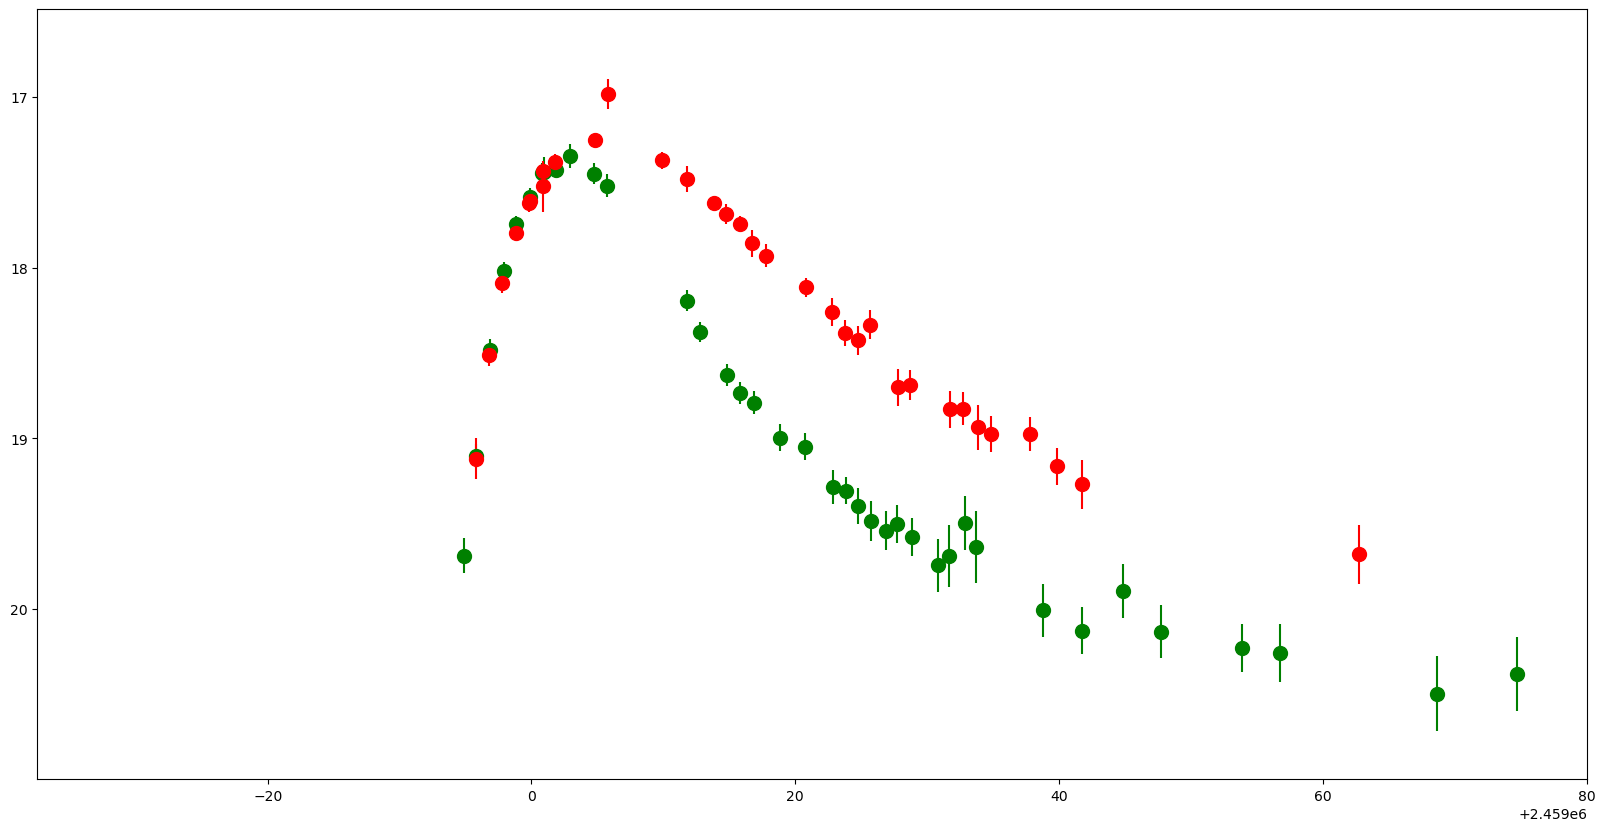

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

fig, ax = plt.subplots(figsize=(20, 10))

#Plot g-band
g_cut = (ztf_lc.ant_passband == 'g') & (ztf_lc.ant_mag != np.nan)
ax.errorbar(Time(ztf_lc.loc[g_cut, 'time'].to_list()).jd,
            ztf_lc.loc[g_cut, 'ant_mag'],
            ztf_lc.loc[g_cut, 'ant_magerr'],
            fmt='o',markersize=10, color='g')

#Plot r-band
r_cut = (ztf_lc.ant_passband == 'R')  & (ztf_lc.ant_mag != np.nan)
ax.errorbar(Time(ztf_lc.loc[r_cut, 'time'].tolist()).jd,
            ztf_lc.loc[r_cut, 'ant_mag'],
            ztf_lc.loc[r_cut, 'ant_magerr'],
            fmt='o',markersize=10, color='r')

ax.set_ylim(np.nanmax(ztf_lc.ant_mag+.5),np.nanmin(ztf_lc.ant_mag-.5))


## Let's use the ZTF data from Antares to download a TESS cutout from a FFI

We'll use lightkurve to query TESSCut to download some cutouts of FFI's around the supernova

In [96]:
import lightkurve as lk

In [98]:
target = lk.search_tesscut(locus.coordinates)
target

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 25,2020,TESScut,1426,"256.7275089869565, 30.271476528985513",0.0
1,TESS Sector 26,2020,TESScut,1426,"256.7275089869565, 30.271476528985513",0.0
2,TESS Sector 52,2022,TESScut,475,"256.7275089869565, 30.271476528985513",0.0


From the [TESS Summary of Sector Observations](https://heasarc.gsfc.nasa.gov/docs/tess/sector.html) we can see that SN 2020lao was detected shortly after Sector 25 began, so their should be data in sectors 25 and 26. Prior to downloading a time-series postage stamp of data around the supernova, we want to set some quality flags for data to exclude. As a starting point, we reccomend:

In [101]:
bitmask = (lk.utils.TessQualityFlags.SafeMode |
           lk.utils.TessQualityFlags.CoarsePoint |
           lk.utils.TessQualityFlags.ManualExclude  |
           lk.utils.TessQualityFlags.Argabrightening | 
           lk.utils.TessQualityFlags.CollateralCosmic)

This excludes a number of known bad data points from sources such as Safe Modes, poor pointing, and "manual" excludes where the TESS pipeline team has flagged a bad cadence. You can read more about them in the [TESS Science Data Products Description](https://archive.stsci.edu/missions/tess/doc/EXP-TESS-ARC-ICD-TM-0014.pdf) (Sec. 9/Pg. 49).

Using this, we want to download a target pixel file (tpf) which is a time-series postage stamp that is a square area around our source at each epoch of TESS observations. SN 2020lao has a host galaxy - we'll start at a 15 x 15 pixel stamp size, and we can retrieve the tpf like so:

In [145]:
tpf_s25=target[0].download(cutout_size=15,quality_bitmask=bitmask)
tpf_s26=target[1].download(cutout_size=15,quality_bitmask=bitmask)

## Lets see what we have!
We can view the tpf with the lightkurve.plot function, or lightkurve.interact

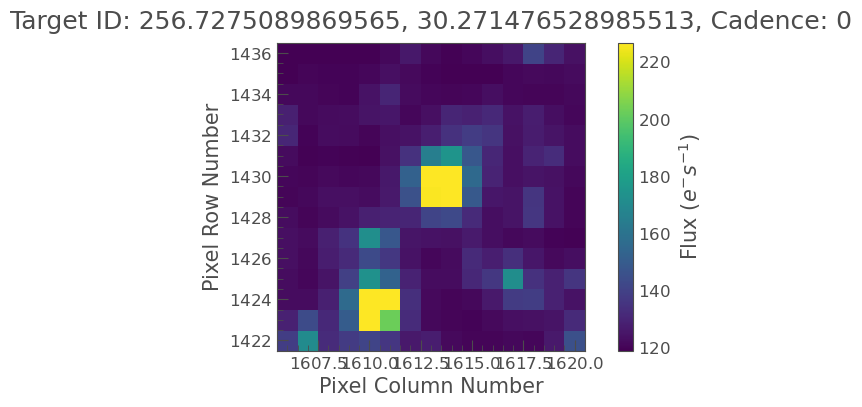

In [146]:
tpf_s25.plot()
tpf_s25.interact()

## Next, we'll get ready to do some simple aperture photometry to capture the SN flux

Lets create a new aperature for photometry using only the highest valued pixels. Given the variance across pixels, we can do this quickly by creating a mask based on a pixels value compared to the standard deviation of the data. Lets create a new aperature using only those pixels with a >20 value:

<AxesSubplot: title={'center': 'Target Aperture'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

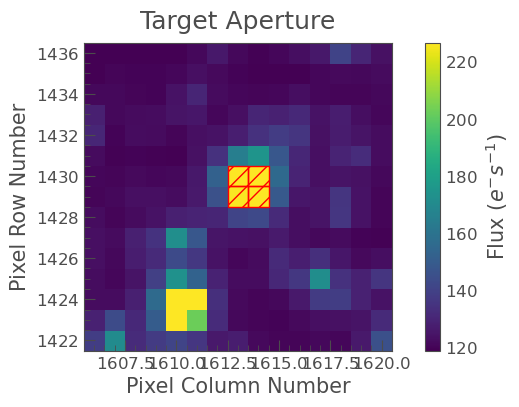

In [147]:
target_mask = tpf_s25.create_threshold_mask(threshold=15)
tpf_s25.plot(aperture_mask=target_mask,title="Target Aperture")

You could also make a boolean pixel aperture mask by hand if you wanted to include or exclude additional pixels. Using this aperature, lets do some simple apereture photometry! First, lets look at our 'raw' lightcurve from out aperture:

<AxesSubplot: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

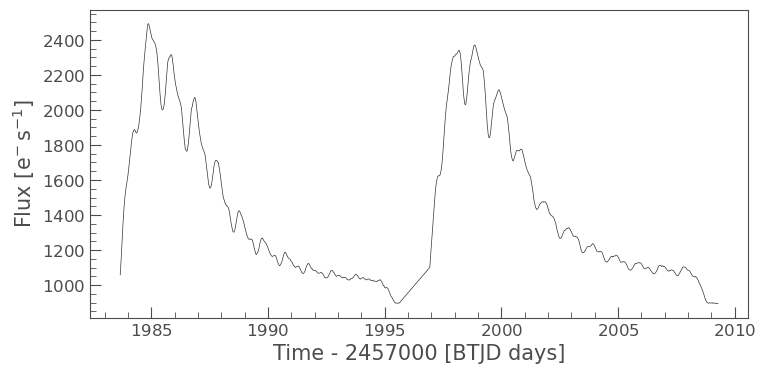

In [148]:
lc_raw=tpf_s25.to_lightcurve(aperture_mask=target_mask)
lc_raw.plot()

## There's clearly still background noise, bad data and instrumental effects in here - lets try and do better!

First things first, lets do our best to subtract out the time-dependant background from our TPF. An easy first pass at this can be to grab an array of pixels that are separated from our target aperture by >1 pixel, and then remove the median of those pixels over time


<AxesSubplot: title={'center': 'Background Aperture'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

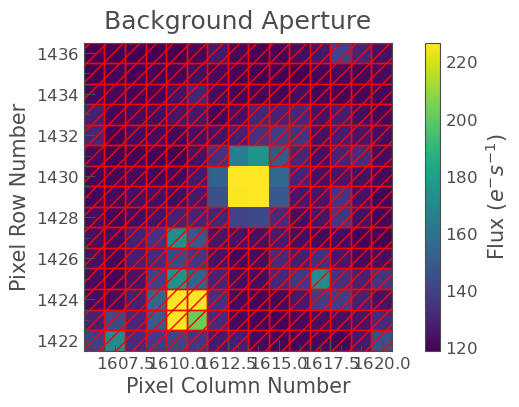

In [149]:
# This function makes a boolean mask larger by one pixel. 
# Our backgroud aperture will then be the inverse of this bigger aperture.
enlarge_aper = lambda x: np.any(np.asarray(np.gradient(x.astype(float))) != 0, axis=0) | x
bigger_mask = enlarge_aper(target_mask)
tpf_s25.plot(aperture_mask=~bigger_mask,title="Background Aperture")

Then, using this new aperture, lets remove the median value of these pixels not in our expanded aperture in each epoch from each epoch, then plot our new background subtracted lightcurv

In [150]:
# Remove the median over time
tpf_s25 -= np.nanmedian(tpf_s25.flux[:, ~bigger_mask], axis=1)[:, None, None]

<AxesSubplot: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

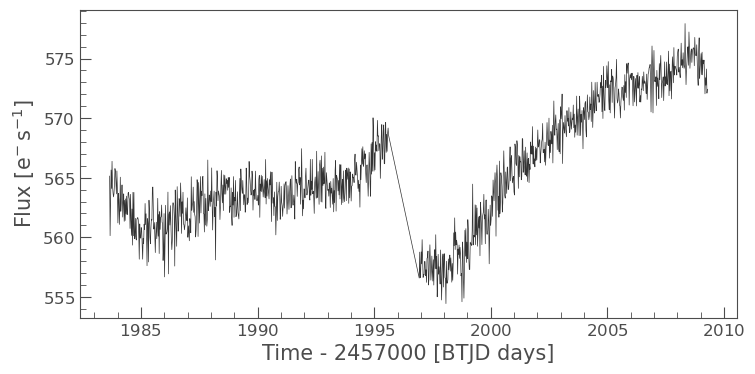

In [151]:
# Make a new lightcurve from our background subtracted tpf
lc_s25=tpf_s25.to_lightcurve(aperture_mask=target_mask)
lc_s25.plot(title='SN 2020lao Sector 25')

## Do this for Sector 26 as well

<AxesSubplot: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

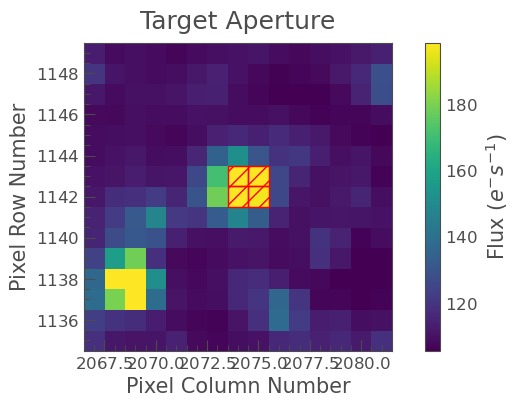

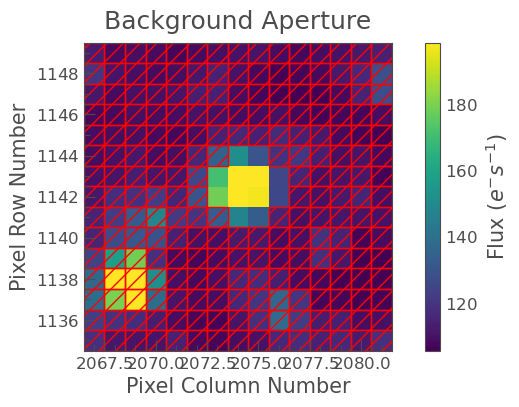

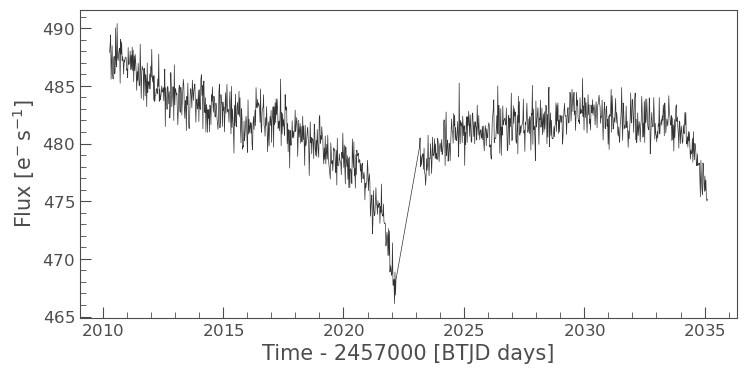

In [152]:
# Create a new threshold based aperture mask
target_mask = tpf_s26.create_threshold_mask(threshold=15)
tpf_s26.plot(aperture_mask=target_mask,title="Target Aperture")
lc_raw=tpf_s26.to_lightcurve(aperture_mask=target_mask)

# This function makes a boolean mask larger by one pixel. 
# Our backgroud aperture will then be the inverse of this bigger aperture.
enlarge_aper = lambda x: np.any(np.asarray(np.gradient(x.astype(float))) != 0, axis=0) | x
bigger_mask = enlarge_aper(target_mask)
tpf_s26.plot(aperture_mask=~bigger_mask,title="Background Aperture")

# Remove the median over time
tpf_s26 -= np.nanmedian(tpf_s26.flux[:, ~bigger_mask], axis=1)[:, None, None]

# Make a new lightcurve from our background subtracted tpf
lc_s26=tpf_s26.to_lightcurve(aperture_mask=target_mask)
lc_s26.plot(title='SN 2020lao Sector 26')

## We're assuming that there are long-baseline (comparable to the sector length) trends in the TESS data that are both real and similar in behavior to that observed by the ground-based ZTF

As a first pass at the reduction - lets do a detrending reduction incorporating a spline that has a similar number of knots to the features observed in the ZTF data

This assumes the least amount of information: That there are long baseline features, and their approximate feature timescales (~days here)
First, we will use lightkurve to get the missions co-trending basis vectors for the target. We will interpolate them to the FFI cadence, since they were calculated on the more rapidly observed TESS TICs.

For a detailed discussion of de-trending vectors and the design matrix, see [Rebekah Hounsell's Noise-Removal tutorial]().


In [169]:
# Obtain the CBVs from the mission
# interpolate from 2min cbvs
ncbvs = 3

cbvc_s25 = lk.CBVCorrector(lc_s25, interpolate_cbvs=True)
multiscale1_s25 = cbvc_s25.cbvs[1].interpolate(lc_s25).to_pandas()
multiscale2_s25 = cbvc_s25.cbvs[2].interpolate(lc_s25).to_pandas()
cbvs_s25 = np.hstack([np.asarray(multiscale2_s25[multiscale2_s25.columns[2:2+ncbvs]])])


cbvc_s26 = lk.CBVCorrector(lc_s26, interpolate_cbvs=True)
multiscale1_s26 = cbvc_s26.cbvs[1].interpolate(lc_s26).to_pandas()
multiscale2_s26 = cbvc_s26.cbvs[2].interpolate(lc_s26).to_pandas()
cbvs_s26 = np.hstack([np.asarray(multiscale2_s26[multiscale2_s26.columns[2:2+ncbvs]])])


Next, we will create a new design matrix collection, using a series of design matrices, each of which correct based on a different systematic measurement . This will include a component that represents the long-timescale information that we want to preserve in our final result.

These are the methods we're using to remove systematics:

 - A design matrix based on the co-trending vectors from TESS TIC's interpolated to the FFIs
 - A design matrix based on the first two components of the background's PCA decomposition
 - A design matrix based on the centroids movement

The long-timescale behavior we want to preserve:

 - A design matrix, based on a spline, created with a number of knots similar to the known features from the ASAS-SN data

Again, for a detailed discussion of de-trending vectors and the design matrix, see [Rebekah Hounsell's Noise-Removal tutorial]().


In [170]:
#Estimate the pointing centroids from the TPF
row_s25,col_s25 = tpf_s25.estimate_centroids()
row_s26,col_s26 = tpf_s26.estimate_centroids()

# These are cadences where there is non NaN flux inside the aperture.
k_s25 = np.isfinite(lc_s25.flux) & np.isfinite(lc_s25.flux_err)
k_s26 = np.isfinite(lc_s26.flux) & np.isfinite(lc_s26.flux_err)

# Design matrix with Cotrending Basis Vectors
dm_cbv_s25 = lk.DesignMatrix(cbvs_s25[k], name='cbvs')#.split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))
dm_cbv_s26 = lk.DesignMatrix(cbvs_s26[k], name='cbvs')#.split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))

# Design matrix with PCA of the pixels outside the aperture
dm_pca_s25 = lk.DesignMatrix(np.nan_to_num(tpf_s25.flux[k][:, ~bigger_mask]), name='bkg').pca(2)
dm_pca_s26 = lk.DesignMatrix(np.nan_to_num(tpf_s26.flux[k][:, ~bigger_mask]), name='bkg').pca(2)

# Design Matrix based off spline
knot_list_tess_s25=np.linspace(np.min(lc_s25.time.value+0.000001),
                           np.max(lc_s25.time.value-0.000001),7).tolist()
knot_list_tess_s26=np.linspace(np.min(lc_s26.time.value+0.000001),
                           np.max(lc_s26.time.value-0.000001),7).tolist()

dm_spline_s25 = lk.designmatrix.create_spline_matrix(lc_s25.time.value,knots=knot_list_tess_s25)
dm_spline_s26 = lk.designmatrix.create_spline_matrix(lc_s26.time.value,knots=knot_list_tess_s26)

# Combined Design Matrix
dm_spline_comb_s25 = lk.DesignMatrixCollection([dm_pca_s25, 
                                            dm_cbv_s25,
                                            dm_spline_s25.append_constant()])
dm_spline_comb_s26 = lk.DesignMatrixCollection([dm_pca_s26, 
                                            dm_cbv_s26,
                                            dm_spline_s26.append_constant()])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1146 but corresponding boolean dimension is 1167

# We will solve for both a normalized.light-curve and a non-normalized lightcurve

As the 'spline' diagnostic component in the normalized light-curve represents the long-timescale multiplicative behavior that we want to preserve


array([<AxesSubplot: ylabel='Flux'>,
       <AxesSubplot: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>],
      dtype=object)

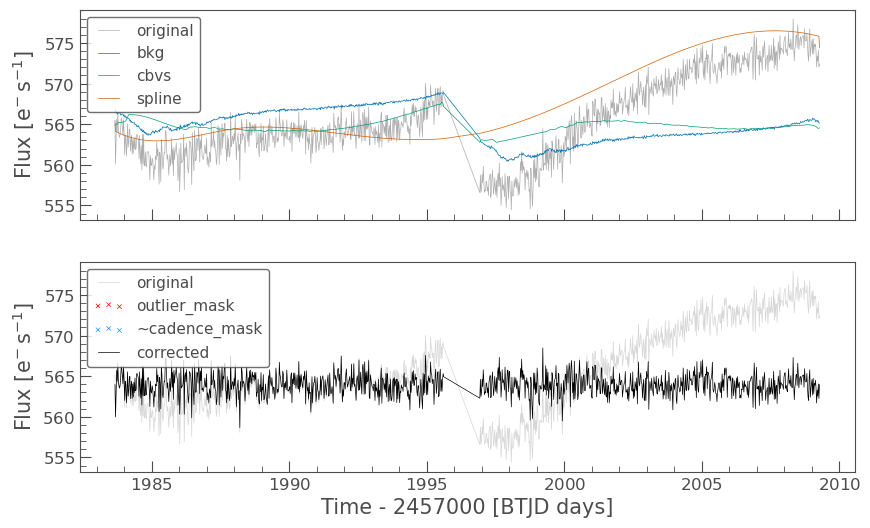

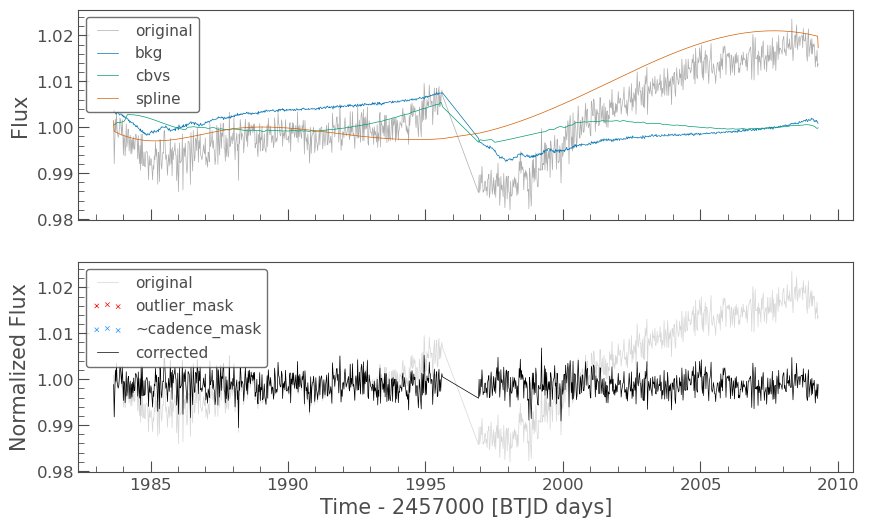

In [162]:
r_spline = lk.RegressionCorrector(lc_s25)
r_spline_norm = lk.RegressionCorrector(lc_s25.normalize())

r_spline.correct(dm_spline_comb)
r_spline_norm.correct(dm_spline_comb)

r_spline.diagnose()
r_spline_norm.diagnose()

# Now, add our best-fit spline back into the calibrated data

Here we're taking the 'corrected lightcurve' from our non-normalized de-trending, which is very flat as we removed numerous systematics, and are multiplying it by the 'diagnostic lightcurve' for the spline for our normalized calibration. This normalized best-fit spline component we believe represents our long-baseline data, and we want re-introduced to our data.


<AxesSubplot: xlabel='Time [JD]', ylabel='Flux'>

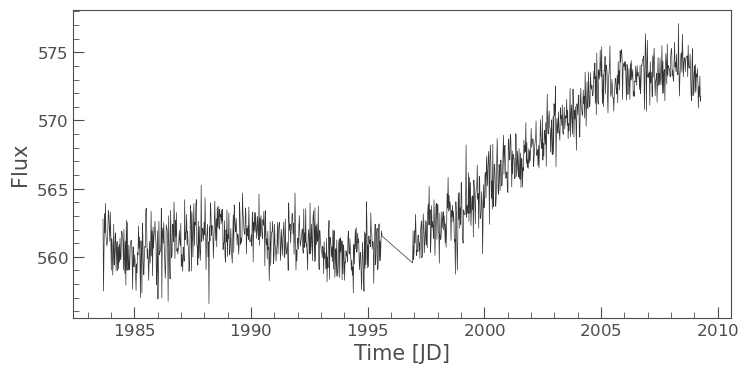

In [164]:
splnorm=r_spline_norm.diagnostic_lightcurves['spline']

lc_SplineCorrected=lk.LightCurve(time=r_spline.corrected_lc.time.value,
                                 flux=r_spline.corrected_lc.flux.value*splnorm.flux.value,
                                 flux_err=r_spline.corrected_lc.flux_err.value)
lc_SplineCorrected.plot()

And, sector 26


## This is now a calibrated, detrended lightcurve with all of the standard mission systematics removed, and our long-term baseline re-introduced. This long-term baseline may or may not have additional systematics, as we only specified timescales in the spline rather than a functional form

The TESS mission has its own systematics that can occur on these timescales that may distort the inherant long-term trends of our target. To go past this, we will essentially need a model of what our long-timescale lightcurve looks like.

To do this, we will assume that it has the same shape as the ASAS-SN normalized light-curve with a multiplicative factor. This may or may not be accurate, and we are doing this to demonstrate technique as much as a final result

To create this model-dependant lightcurve we will need a smooth interpolation of the ASAS-SN data with a normalized value at each point. More complicated models are left to the user and their specific science needs.

For our interpolation needs, we will use a gaussian process regressor with a RBF kernel and a white noise kernel (to capture the error behavior) of our points.


In [165]:
# We want to do our regression with the asas-sn data, but predict on the tess epochs
def gpinterp(btjd,flux,tessjd):
    time=np.array(btjd).reshape(-1,1)
    val=np.array(flux)
    kernel =1.0*RBF(length_scale=2, length_scale_bounds=(0.5,1e2)) \
    + WhiteKernel(noise_level=1)
    
    gp=GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    gp.fit(time, val)
    time_pred=tessjd.reshape(-1,1)
    val_pred,val_sigma = gp.predict(time_pred, return_std=True)
    return time_pred.reshape(-1), val_pred, val_sigma

